In [1]:
from utils import rinomina_classi_in_dir, undersample_dataset, count_images_per_class, split_train_val
from data_loader import get_data_loaders
from model import create_transfer_model
from train import train_model
from evaluate import evaluate_model, plot_training

import torch

In [2]:
# Parametri
original_dir = "DataSet/PlantVillage"
balanced_dir = "DataSet/PlantVillage_Balanced"
split_dir = "DataSet/PlantVillage_Split"
img_size = (224, 224)
batch_size = 64
epochs = 10
val_ratio = 0.2

In [3]:
# Rinomina classi
rinomina_classi_in_dir(original_dir)

In [4]:
# Usa GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Undersampling per bilanciare
undersample_dataset(original_dir, balanced_dir, max_per_class=1000)

✅ Dataset ridotto salvato in: DataSet/PlantVillage_Balanced


In [6]:
# Conta immagini
print("Distribuzione originale:", count_images_per_class(original_dir))
print("Distribuzione bilanciata:", count_images_per_class(balanced_dir))

Distribuzione originale: {'pep_bell_Bacterial_spot': 976, 'pep_bell_healthy': 1478, 'pot_Early_blight': 1000, 'pot_healthy': 152, 'pot_Late_blight': 1000, 'tom_Bacterial_spot': 2127, 'tom_Early_blight': 1000, 'tom_healthy': 1591, 'tom_Late_blight': 1909, 'tom_Leaf_Mold': 952, 'tom_Septoria_leaf_spot': 1771, 'tom_Spider_mites_Two_spotted_spider_mite': 1676, 'tom_Target_Spot': 1404, 'tom_Tomato_mosaic_virus': 373, 'tom_Tomato_YellowLeaf_Curl_Virus': 3208}
Distribuzione bilanciata: {'pep_bell_Bacterial_spot': 976, 'pep_bell_healthy': 1000, 'pot_Early_blight': 1000, 'pot_healthy': 152, 'pot_Late_blight': 1000, 'tom_Bacterial_spot': 1000, 'tom_Early_blight': 1000, 'tom_healthy': 1000, 'tom_Late_blight': 1000, 'tom_Leaf_Mold': 952, 'tom_Septoria_leaf_spot': 1000, 'tom_Spider_mites_Two_spotted_spider_mite': 1000, 'tom_Target_Spot': 1000, 'tom_Tomato_mosaic_virus': 373, 'tom_Tomato_YellowLeaf_Curl_Virus': 1000}


In [7]:
# Step 3 - Dividi in train/val
split_train_val(balanced_dir, split_dir, val_ratio=val_ratio)

In [8]:
# Step 4 - Prepara DataLoader
train_loader, val_loader, class_names = get_data_loaders(
    split_dir, img_size=img_size, batch_size=batch_size)

In [9]:
# Step 5 - Crea modello transfer learning
model = create_transfer_model(num_classes=len(class_names))
model = model.to(device)

In [10]:
# Step 6 - Allena il modello
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, device, epochs=epochs)

Epoch 1/10: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]


Train Loss: 2.3558, Train Acc: 0.2812
Val Loss: 1.9127, Val Acc: 0.5633


Epoch 2/10: 100%|██████████| 169/169 [00:43<00:00,  3.91it/s]


Train Loss: 1.8376, Train Acc: 0.5338
Val Loss: 1.4774, Val Acc: 0.6944


Epoch 3/10: 100%|██████████| 169/169 [00:42<00:00,  4.02it/s]


Train Loss: 1.5455, Train Acc: 0.6208
Val Loss: 1.2084, Val Acc: 0.7542


Epoch 4/10: 100%|██████████| 169/169 [00:42<00:00,  3.98it/s]


Train Loss: 1.3651, Train Acc: 0.6483
Val Loss: 1.0730, Val Acc: 0.7609


Epoch 5/10: 100%|██████████| 169/169 [00:42<00:00,  3.98it/s]


Train Loss: 1.2466, Train Acc: 0.6730
Val Loss: 0.9527, Val Acc: 0.7954


Epoch 6/10: 100%|██████████| 169/169 [00:42<00:00,  4.02it/s]


Train Loss: 1.1488, Train Acc: 0.6905
Val Loss: 0.8523, Val Acc: 0.7999


Epoch 7/10: 100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


Train Loss: 1.0742, Train Acc: 0.7151
Val Loss: 0.7918, Val Acc: 0.8154


Epoch 8/10: 100%|██████████| 169/169 [00:42<00:00,  4.00it/s]


Train Loss: 1.0254, Train Acc: 0.7200
Val Loss: 0.7541, Val Acc: 0.8188


Epoch 9/10: 100%|██████████| 169/169 [00:41<00:00,  4.11it/s]


Train Loss: 0.9811, Train Acc: 0.7272
Val Loss: 0.7084, Val Acc: 0.8273


Epoch 10/10: 100%|██████████| 169/169 [00:41<00:00,  4.10it/s]


Train Loss: 0.9479, Train Acc: 0.7322
Val Loss: 0.6750, Val Acc: 0.8288


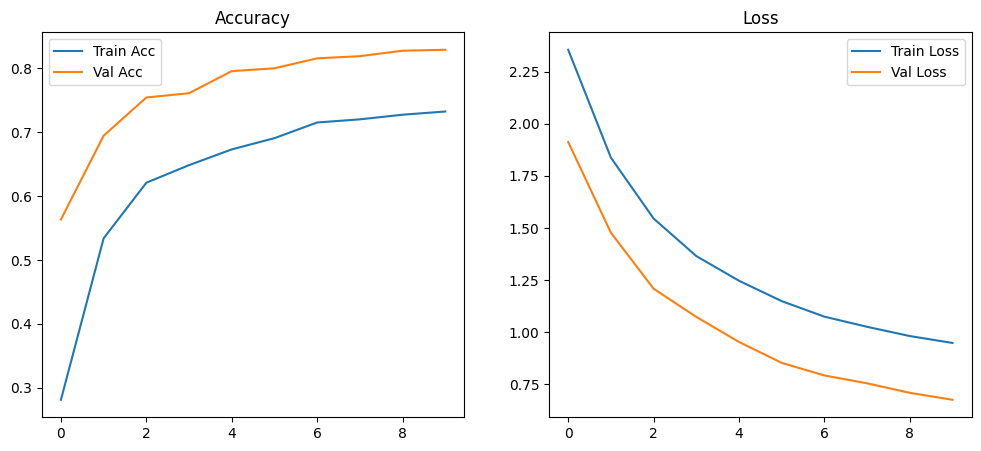

In [11]:
# Step 7 - Visualizza andamento training
plot_training(train_losses, val_losses, train_accs, val_accs)

Classification Report:
                                          precision    recall  f1-score   support

                 pep_bell_Bacterial_spot       0.90      0.95      0.93       196
                        pep_bell_healthy       0.86      0.98      0.92       200
                        pot_Early_blight       0.93      0.98      0.96       200
                         pot_Late_blight       0.88      0.83      0.86       200
                             pot_healthy       0.96      0.77      0.86        31
                      tom_Bacterial_spot       0.96      0.60      0.74       200
                        tom_Early_blight       0.84      0.66      0.74       200
                         tom_Late_blight       0.82      0.74      0.78       200
                           tom_Leaf_Mold       0.84      0.82      0.83       191
                  tom_Septoria_leaf_spot       0.62      0.91      0.74       200
tom_Spider_mites_Two_spotted_spider_mite       0.67      0.90      0.76   

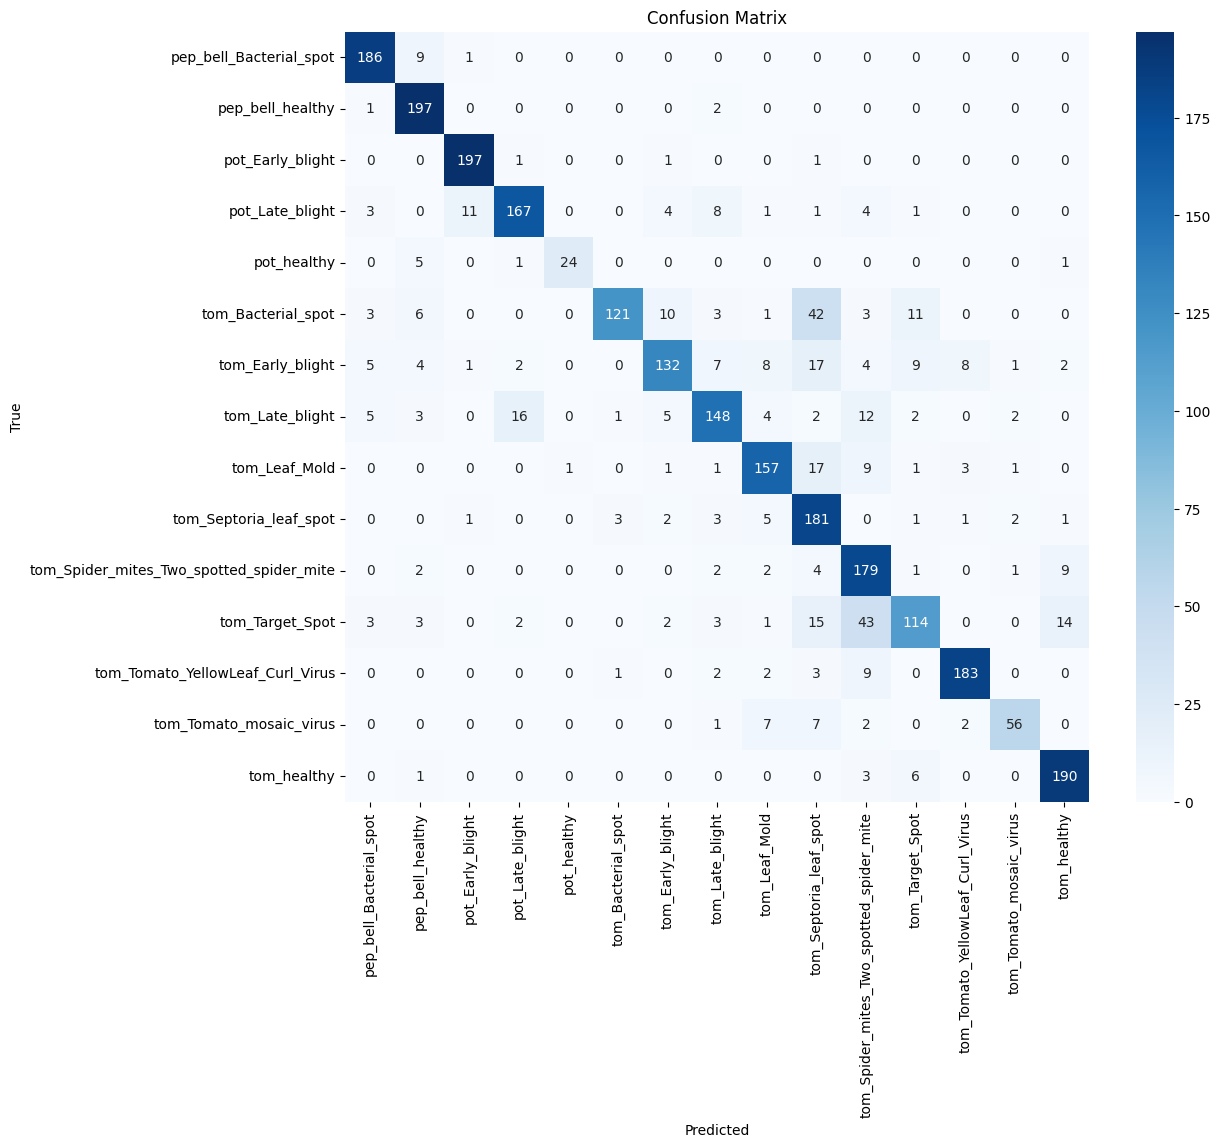

In [12]:
# Step 8 - Valuta il modello su validation set
evaluate_model(model, val_loader, device, class_names)

In [13]:
# Step 9 - Salva modello
torch.save(model.state_dict(), "plantvillage_transfer_model.pth")
print("✅ Modello salvato in plantvillage_transfer_model.pth")

✅ Modello salvato in plantvillage_transfer_model.pth
